In [13]:
BENCHMARK_TOOL = 'NVPROF' # or 'NCU'

import subprocess
import numpy as np
import pandas as pd
import io
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm 

In [ ]:
KERNELS = [
    "rgb2hsv", 
    "rgb2hsv_MINIMUMDIVERGENCE",
    "rgb2hsv_COORDINATEDOUTPUTS",
    "histogram",
    "histogram_WITHSHAREDMEMORY",
    "histogram_WITHSHAREDMEMORYANDHARDCODEDSIZE",
    "",
    "",
    ""
]

In [14]:
def read_nvprof(output: str) -> pd.DataFrame:
    csv = output.split('\\n')
    columns = csv[3].split('\",\"')
    data = csv[4:]

    return pd.read_csv(io.StringIO('\n'.join(data)), names=columns)

    
def read_ncu(output: str) -> pd.DataFrame:
    csv = output.split('\\n')
    columns = csv[2].split('\",\"')
    data = csv[4:]

    return pd.read_csv(io.StringIO('\n'.join(data)), names=columns)

def benchmark_kernel(exe_path: str, *args) -> str :
    if BENCHMARK_TOOL == 'NVPROF':
        return str(subprocess.check_output(
            ['nvprof', '--print-gpu-trace', '--csv', exe_path, *args], 
            stderr=subprocess.STDOUT
        ))
    elif BENCHMARK_TOOL == 'NCU':
        return str(subprocess.check_output(
            ['ncu','--csv', exe_path, *args], 
            stderr=subprocess.STDOUT, shell=True
        ))

def read_benchmark(output: str) -> pd.DataFrame:
    if BENCHMARK_TOOL == 'NVPROF':
        return read_nvprof(output)
    elif BENCHMARK_TOOL == 'NCU':
        return read_ncu(output)

def get_kernel_duration(df: pd.DataFrame, kernelNum=0) -> float:
    if BENCHMARK_TOOL == 'NVPROF':
        # conversion en ms 
        if df.loc[0, 'Duration'] == "ms":
            return float(df.loc[kernelNum + 1, 'Duration']) 
        if df.loc[0, 'Duration'] == "s":
            return float(df.loc[kernelNum + 1, 'Duration']) * 1e3
        # probablement en micro seconde
        return float(df.loc[kernelNum + 1, 'Duration']) * 1e-3
    elif BENCHMARK_TOOL == 'NCU':
        return float(df[df['Metric Name'] == 'Duration']['Metric Value'].to_numpy().item().replace(',','')) * 1e-6

In [15]:
# Renvoie les durée moyennes en fonction de variation de tailles de l'axe X des blocs pour un certain kernel
def evaluateBlocSize(kernelType, nTry = 10):  
    durations = []
    sizes = []
    avg = 0
    xBlockSize, yBlockSize = 1, 1
    
    while xBlockSize <= 1024:
        for _ in range(nTry) :         
            avg += get_kernel_duration(read_benchmark(
                benchmark_kernel("./hist", 
                    "-f", "./img/chateau.png", 
                    "-b", str(kernelType), 
                    "-d", str(xBlockSize), str(yBlockSize)
                )
            ), kernelType)

        avg /= nTry
        durations.append(avg)    
        sizes.append(xBlockSize)
        xBlockSize *= 2
    return durations, sizes

Évaluation des kernels suivant la variation de la taille des blocs sur l'axe X


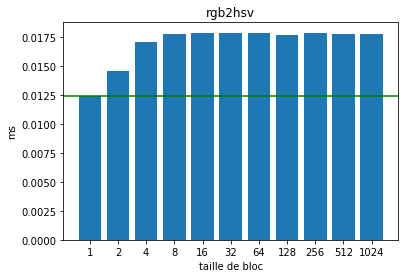

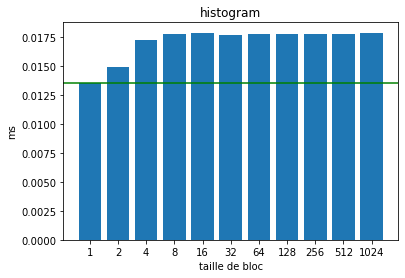

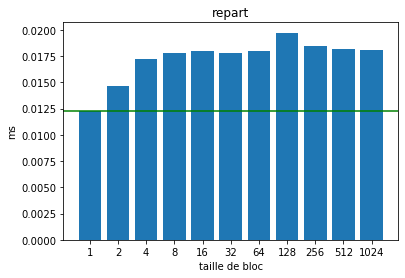

KeyboardInterrupt: 

In [16]:
def showHistogramDuration(durations, sizes, title, xLabel, yLabel):
    plt.title(title)  
    plt.xlabel(xLabel) 
    plt.ylabel(yLabel) 
    plt.bar(np.array(sizes).astype(str), np.array(durations), width=.8)
    plt.axhline(min(durations), ls='-', color='green')
    plt.show()

def showHistogramOfKernels(kernels, nTry = 10):  
    i = 0
    for k in kernels: 
        durations, sizes = evaluateBlocSize(i, nTry)
        showHistogramDuration(durations, sizes, k, "taille de bloc", "ms") 
        i+=1
 
print("Évaluation des kernels suivant la variation de la taille des blocs sur l'axe X") 
showHistogramOfKernels(KERNELS, 5)

In [ ]:
def evaluate2DBlocSize(kernelType, nTry = 10):  
    durations = []
    sizes = []
    step = 128
    xBlockSize = 1

    while xBlockSize <= 1024:
        yBlockSize = 1
        durations.append([])
        while yBlockSize <= 1024:
            #if (xBlockSize + yBlockSize) > 1024:
            #    durations[-1].append(-1)    
            #    yBlockSize += step
            #    continue
            
            avg = 0
            for _ in range(nTry) :         
                avg += get_kernel_duration(read_benchmark(
                    benchmark_kernel("./hist", 
                        "-f", "./img/chateau.png", 
                        "-b", str(kernelType), 
                        "-d", str(xBlockSize), str(yBlockSize)
                    )
                ), kernelType)

            avg /= nTry
            durations[-1].append(avg)    
            yBlockSize += step
        sizes.append(xBlockSize)
        xBlockSize += step
    return durations, sizes
 

In [ ]:
 
def showHistogramDuration3D_1(durations, sizesX, sizesY, dLabel, xLabel, yLabel): 
    # get colormap
    ncolors = 256
    color_array = plt.get_cmap('spring')(range(ncolors))

    # change alpha values
    color_array[:,-1] = [0.5] * 256

    # create a colormap object
    map_object = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)

    # register this new colormap with matplotlib
    plt.register_cmap(cmap=map_object)

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d') 
    X, Y = np.meshgrid(sizesX, sizesY)   
    surf = ax.plot_surface(X, Y, np.array(durations), cmap='rainbow_alpha',
        linewidth=0, antialiased=False) 




    # Customize the z axis. 
    #ax.set_zlim(2, 10)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.05f'))
    
    ax.legend() 
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel) 
    ax.set_zlabel(dLabel)
    # Add a color bar which maps values to colors.evaluate2DBlocSize(4, 1) 
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    
def showHistogramDuration3D_2(durations, sizesX, sizesY, dLabel, xLabel, yLabel): 
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    Z = np.array(durations)  
    ax.plot_trisurf(sizesX, sizesY, Z, cmap=cm.coolwarm,
        linewidth=0.2, antialiased=True) 

    # Customize the z axis. 
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.05f'))
    
    ax.legend()
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.set_zlabel(dLabel) 

    # Add a color bar which maps values to colors.evaluate2DBlocSize(4, 1) 
    #fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
      
     

In [ ]:
print("Variation de la taille des blocs rgb to hsv")
durations, sizes = evaluate2DBlocSize(0, 1)   

Variation de la taille des blocs rgb to hsv


In [ ]:
showHistogramDuration3D_1(durations, sizes, sizes, "durée (en ms)", "taille x", "taille y") 

NameError: name 'LinearSegmentedColormap' is not defined

In [ ]:


print("Variation de la taille des blocs histogram")
durations, sizes = evaluate2DBlocSize(3, 10)  
showHistogramDuration3D_1(durations, sizes, sizes, "durée (en ms)", "taille x", "taille y")

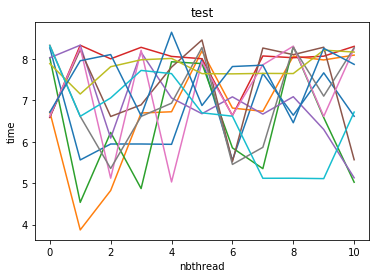

In [ ]:
def showHistogramDurationtest(durations, sizes, title, xLabel, yLabel):
    plt.title(title)  
    plt.xlabel(xLabel) 
    plt.ylabel(yLabel) 
    for tab in durations :
        plt.plot(tab)
    plt.show()

showHistogramDurationtest(durations, sizes, "test", "nbthread", )